# Scrapy
Resumo da <a href = 'https://docs.scrapy.org/en/latest/intro/'>documentação</a>.

| Capítulo 	| Assunto                       	    |
|----------	|-------------------------------	    |
| I        	| Novo Projeto Scrapy           	    |
| II       	| Parsing Nativo do Scrapy          	|
| III      	| Exemplo de Parsing via Scrapy Shell   |
| IV      	| Exemplo de Parsing via Spider         |

<h2 style = "color:red">I - Novo Projeto Scrapy </h2>

### Instalação do framework: 

```bash
$ pip install Scrapy
```

### Criação de um novo projeto
Digitar no terminal: 

```bash
$ scrapy startproject nome_do_projeto
```

O que criará a pasta ```nome_do_projeto``` com a seguinte estrutura: 

```bash
nome_do_projeto/
    scrapy.cfg            # Configurações do deplou

    nome_do_projeto/             # Módulo do python a ser importado
        __init__.py

        items.py          # Arquivo de definição dos itens do projeto

        middlewares.py    # Arquivo de middleware do projeto

        pipelines.py      # Arquivo de pipelines do projeto

        settings.py       # Arquivo de configurações do projeto

        spiders/          # Pasta onde serão colocados novos spiders
            __init__.py
```


### Arqtuitetura de um spider:  

Exemplo de spider da documentação:  

```python
import scrapy


class QuotesSpider(scrapy.Spider):
    name = "quotes" #1

    def start_requests(self): #2
        urls = [
            'http://quotes.toscrape.com/page/1/',
            'http://quotes.toscrape.com/page/2/',
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response): #3
        page = response.url.split("/")[-2]
        filename = 'quotes-%s.html' % page
        with open(filename, 'wb') as f:
            f.write(response.body)
        self.log('Saved file %s' % filename)
```

#### ``` 1 : name = "quotes" ```
Define o identificador do spider. **Não pode haver mais de um spider com mesmo nome em um projeto**. 

#### ```2: start_requests()```
Método que **deve retornar um iterável¹ de Requests** o qual indica de onde o Spider começará o crawling.  

#### ```3: parse()```
Função que lida com as respostas das requisições. Normalmente:
- Faz o parsing a partir do HTML das respostas
- Salva o conteúdo tratado em um dicionário 
- Encontra novas URL's para continuar o processo 
- Cria novas requests para as URL's encontradas.

#### ```response```
Instância de ```TextResponse```**²** que armazena o conteúdo da página, bem como métodos úteis apra lider com ele.


¹Objeto capaz de retornar seus próprios membros um a um, habilitando-o a ser iterado por um for. No caso, uma lista de request ou função geradora. 
²Adiciona capacidade de encoding à classe base ```Response```, que originalmente só é capaz de lidar com dados binários, como imagens, sons ou medias. 

### Onde criar e salvar novos spiders
Novos spiders devem ser **salvos na pasta ```spiders/```**. O exemplo o salva como ```quotes_spiders.py```


### Rodando um spider: 
```bash
$ cd nome_do_projeto/
$ scrapy crawl quotes
```
**```scrapy crawl quotes``` deve ser utilizado na pasta ```nome_do_projeto/``` raiz mais alta do projeto, e não na subpasta**

O exemplo em questão salvará o HTML respondidos pelos URLs na raiz do projeto como ```quotes-1.html``` e ```quotes-2.html```.





<hr style = "height: 1px">

<h2 style = "color:red">II - Parsing Nativo no Scrapy </h2>

Seletores nativos selecionam elementos por **css** ou **xpath**. 

#### Modo shell-interativo do scrapy: 
Permite testar comandos rapidamente, é ativado com: 
```bash
$ scrapy shell 'http://quotes.toscrape.com'
```

### Seletor por CSS
Utiliza o método ```response.css()```.

**1.Argumento**: string contendo um seletor de css.

**2.Retorno**: Instância de SelectorList. 

#### Exemplos de Seleção: 
* **Todas as instâncias de uma tag**:  

```python
response.css('div') # SelectorList com todas as divs
```

* **Sintaxe pai-filho** por ```pai filho```:

```python
response.css('div span') # SelectorList com spans filhos de uma div.
```

- **Classes** por ```.classe``` ou  **ids** por ```#id```: 

```python
response.css('div span.text') # SelectorList com spans de classe text filhos de uma div. 
```
* **Atributos por ```[attribute="value"]```**:


```python
response.css('[itemprop = "text"]') # Lista de Selectors, cujos elementos possuem um atributo **itemprop** de valor **text**.

# Retorno:
# <Selector xpath="descendant-or-self::*[@itemprop = 'text']" data='<span class="text" itemprop="text">“T...'>
```

Como o retorno de ```response.css``` é uma lista, é possível iterar sobre a mesma ou acessar elementos por index: 

* **Acessar Selector específico por Índice com ```SelectorList[]```** 

```python
response.css('div span.text')[0] # primeiro Selector que atende ao seletor de CSS

# Retorno: 
# <Selector xpath="descendant-or-self::div/descendant-or-self::*/span[@class and contains(concat(' ', normalize-space(@class), ' '), ' text ')]" data='<span class="text" itemprop="text">“T...'>
```

### **Acessando atributos de um Selector**
É possível listar todos os atributos (de HTML) de um Selector ou lista de Selectors acessando a propriedade```.attrib```. 

```python
images = response.css("img")
images.attrib

# Imprime {'href': '/', 'style': 'text-decoration: none'}
```

* **Retornar valores de um Atributo via ```.attrib[]```**


```python
list = response.css("a") 
for link in list:
    print(link.attrib[href])
    
# Imprime: 
# /login
# /author/Albert-Einstein
# ...
# https://www.goodreads.com/quotes
# https://scrapinghub.com
```

### **Tag/ Elemento de um Selector como String:**
Os métodos **.get()** e **.getall()** de uma **SelectorList** permitem acessar **uma Tag como String de fato**.

* **get( ) :**

    Retorno: **String** com o elemento do **primeiro Selector** que atende ao seletor CSS


```python
response.css('div span.text').get()                                                                               

# Retorno:
#'<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>'
```

* **getall( ) :**

    Retorno: **Lista de Strings** com o elemento do **cada um dos Selectores** que atendem ao seletor CSS.
```python
response.css('div span.text').getall()                                                                                                                              
# Retorno: 
# ['<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>',
# '<span class="text" itemprop="text">“It is our choices, Harry, that show what we truly are, far more than our abilities.”</span>']
# ...
```

### **Text nodes via ```::text``` e seleção por atributo**
Os exemplos acima, da maneira como estão, retornaram o **outerHTML** dos elementos selecionados. Pelos padrões da W3C, seletores de CSS **não suportam text-nodes** ou **Valores de atributos**. Portanto, foi implementada uma solução do Scrapy: 

#### <span style = "color:red"><strong>OBSERVAÇÃO:</strong></span>: Exemplos de ::text da documentação tem como base outro website, rodar: 

```bash
$ scrapy shell https://docs.scrapy.org/en/latest/_static/selectors-sample1.html
```

**1. Para selecionar text nodes filhos, usar ```::text```**:
```python
response.css('title::text').get() # Seleciona nós-texto filhos de um nó pai <title> 
# Imprime 'Example website'
```
Observação: ```foo::text``` não retorna nada se ```foo``` existe, mas não contém texto. Por isso, recomenda-se o uso de ```default = ''``` caso se deseje forçar a padronização do retorno. 

```python
response.css('img::text').get() # Retorna []
response.css('img::text').get(default = '') # Retorna ''

```

**2. Para selecionar text nodes descendentes (não apenas filhos diretos), usar  ```*::text```** 
```python
response.css('#images *::text').getall()
# Imprime: 
#['\n   ',
# 'Name: My image 1 ',
# '\n   ',
# 'Name: My image 2 ',
# '\n   ',
# ...
# 'Name: My image 5 ',
# '\n  ']
```

**3. Para selecionar valores de atributos, usar ```::attr(nome)```onde nome é o nome do atributo cujo valor se deseja:**

```python
response.css('a::attr(href)').getall()
# Retorna:
# ['image1.html',
# 'image2.html',
# 'image3.html',
# 'image4.html',
# 'image5.html']
```



<hr style = "height: 1px">

<h2 style = "color:red">III - Exemplo de parsing via Scrapy Shell </h2>

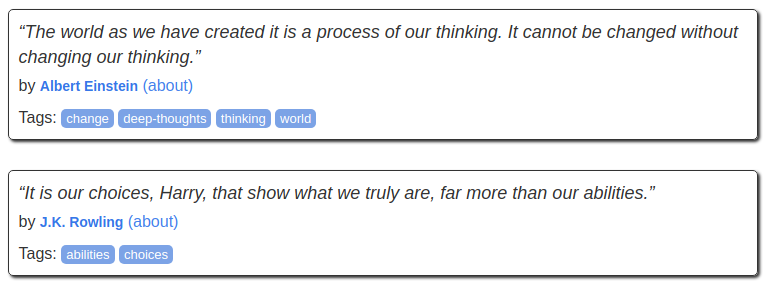

### 1. Entrar no Scrapy Shell
```bash
$ scrapy shell 'http://quotes.toscrape.com/page/1/'
```


### 2. Função que extrai quotes de uma página: 
```python
quote_selectors = response.css(".quote") #Lista de Selectors

quotes = [] #lista de dicionários de quote 

for selector in quote_selectors:
    quote = { #dicionário de cada quote
        "text" : selector.css('.text::text').get(),
        "author": selector.css('.author::text').get(),
        "tags": selector.css('.tag ::text').getall(),
    }
    quotes.append(quote)
    
print(quotes)
```

### 3. Retorno: 
```python
[{'text': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'author': 'Albert Einstein',
  'tags': ['change', 'deep-thoughts', 'thinking', 'world']},
 {'text': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'author': 'J.K. Rowling',
  'tags': ['abilities', 'choices']},
# ... omitted for brevity
 {'text': '“A day without sunshine is like, you know, night.”',
  'author': 'Steve Martin',
  'tags': ['humor', 'obvious', 'simile']}]
```

<hr style = "height: 1px">

---------------------------------------------------------

```python
import scrapy
from scrapy.crawler import CrawlerProcess

class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'http://quotes.toscrape.com/page/2/',
    ]

    def parse(self, response):
        for quote in response.css('.quote'): # Lista de Selectors
            yield {
                "text" : selector.css('.text::text').get(),
                "author": selector.css('.author::text').get(),
                "tags": selector.css('.tag ::text').getall(),
            }

process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(QuotesSpider)
process.start() # the script will block here until the crawling is finished
```

## III - Parsing usando Beautiful Soup


---------------------------------------------------------